In [834]:
!pip install p3_data

In [835]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import json
from io import StringIO
import importlib

In [836]:
import p3_data
from p3_data import (glob_file_list, load_json_from_file, merge_dicts, plot_groups, 
    get_varying_column_names, filter_dataframe, take_varying_columns,
    load_json_records_as_dataframe)

In [1557]:
# Load result files from P3 Test Driver
src_files = []

# Pulsar 2.6.0 ecs s3 tier2 07.07.2020

## attempt1 brokers out of direct memory
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/Pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-18tests-attempt1-broker-outofdirectmem/data/p3_test_driver/results/*.json']

## attempt2 bookies out of direct memory
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-19tests-attempt2-bk-outofdirectmem/data/p3_test_driver/results/*.json']

## attempt3 broker out of direct memory
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-19tests-attempt3-broker-directmemOOM/data/p3_test_driver/results/*.json']
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-19tests-attempt3-broker-directmemOOM/data/p3_test_driver/results_cleared/*.json']

# Pulsar 2.6.0 ecs s3 tier2 07.07.2020
## attempt4 broker out of direct memory - 52 tests
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-52tests-attempt4/data/p3_test_driver/results_cleared/*.json']

# pulsar-2.6.0-no-tiered-10.07.2020-46tests-success
src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-no-tiered-10.07.2020-46tests-success/data/p3_test_driver/results_cleared/*.json']
#---------------------------------------------------------

### Pulsar 2.5.2 15.06.2020 44 tests different amount of workers
# src_files += ['../../../../../tests/pulsar_2.5.2_44_tests_15.06/data/p3_test_driver/results/*.json']

### Pulsar 2.5.2 17.06.2020 44 tests different amount of workers
#src_files += ['../../../../../tests/Pulsar-2.5.2-17.06.20-44tests/data/p3_test_driver/results_cleared/*.json']

#-------------------------------------------------------------------------
# Pulsar fresh tests 2.5.2 
src_files += ['../../../../../tests/Pulsar-2.5.2-no_tier2_11.07.2020/pulsar-2.5.2.-10k-1p-13tests-11.07.2020/data/p3_test_driver/results/*.json']

# Pravega 0.8.0-2577.15b0f5eb9 tier2 29.06.2020
#src_files += ['../../../../tests/pravega-15b0f5eb9-tier2-29.06.2020-10k-100b/pravega-0.8.0-2577.15b0f5eb9-tier2-10k-28tests-29.06.2020/data/p3_test_driver/results/*.json']

# pravega-0.8.0-2656.1c40f1e-no_netty_Isilon-nfs-tier2 09.07.2020 48 tests success
#src_files += ['../../../../../tests/Pravega-1c40f1e-NO_NETTY-nfs-Isilon-tier2-48tests-succsess-09.07.2020/data/p3_test_driver/results/*.json']

### PRAVEGA 15b0f5eb9 (master) Isilon nfs omb 2b28b32 (no_netty) 09.07.2020 48tests success
#src_files += ['../../../../../tests/PRAVEGA-15b0f5eb9-Isilon-nfs-omb-2b28b32-09.07.2020-48tests/data/p3_test_driver/results/*.json']

raw_df = load_json_records_as_dataframe(src=src_files, ignore_error=True)

Loading records from 56 files...


In [1558]:
# Clean raw results
def clean_result(result):
    try:
        r = result.copy()
        r['utc_begin'] = pd.to_datetime(r['utc_begin'], utc=True)
        r['utc_end'] = pd.to_datetime(r['utc_end'], utc=True)
        r['git_commit'] = r['git_commit'].split(' ')[0]
        r['driverName'] = r['driver']['name']
        if r['driverName'] == 'Pulsar':
            r = merge_dicts(r, r['driver']['client']['persistence'])
        r = merge_dicts(r, r['workload'])
        del r['workload']
        r = merge_dicts(r, r['omb_results'])
        if 'ansible_vars' in r and isinstance(r['ansible_vars'], dict):
            r = merge_dicts(r, r['ansible_vars'])
        if r['driverName'] == 'Pravega':
            if 'pravegaVersion' not in r:
                r['pravegaVersion'] = '1c40f1e-no_netty_Isilon-nfs-tier2'
            r['pravegaVersion'] = r['pravegaVersion'].replace('-SNAPSHOT','')
        for k in list(r.keys()):
            if 'Quantiles' in k:
                r[k] = pd.Series(data=[float(q) for q in r[k].keys()], index=list(r[k].values())).sort_index() / 100
            elif isinstance(r[k], list) and 'Rate' in k:
                r[k] = pd.Series(r[k])
                r['%sMean' % k] = r[k].mean()
        r['numWorkloadWorkers'] = int(r.get('numWorkers', 0))
        r['throttleEventsPerSec'] = r['producerRate']
        r['publishRateEventsPerSecMean'] = r['publishRateMean']
        r['consumeRateEventsPerSecMean'] = r['consumeRateMean']
        r['publishRateMBPerSecMean'] = r['publishRateMean'] * r['messageSize'] * 1e-6
        r['consumeRateMBPerSecMean'] = r['consumeRateMean'] * r['messageSize'] * 1e-6
        r['publishLatencyMsAvg'] = r['aggregatedPublishLatencyAvg']
        r['publishLatencyMs50Pct'] = r['aggregatedPublishLatency50pct']
        r['publishLatencyMs99Pct'] = r['aggregatedPublishLatency99pct']
        r['endToEndLatencyMsAvg'] = r['aggregatedEndToEndLatencyAvg']
        r['endToEndLatencyMs50Pct'] = r['aggregatedEndToEndLatency50pct']
        r['endToEndLatencyMs99Pct'] = r['aggregatedEndToEndLatency99pct']
        
        if r['driverName'] == 'Pulsar':
            r['version'] = r['pulsarVersion']
            
        if r['driverName'] == 'Pravega':    
            r['version'] = r['pravegaVersion']   
        
        return pd.Series(r)
    except Exception as e:
        print('ERROR: %s: %s' % (r['test_uuid'], e))
        # raise e

In [1559]:
# r = clean_result(raw_df.iloc[-1])
# pd.DataFrame(r)

In [1560]:
clean_df = raw_df.apply(clean_result, axis=1)
clean_df = clean_df.set_index('test_uuid', drop=False)
clean_df = clean_df[clean_df.error==False]
clean_df = clean_df.sort_values(['utc_begin'])

In [1561]:
# Show list of columns
clean_df.columns.values

array(['ansible', 'ansible_vars', 'aws-ec2', 'build', 'command_timed_out',
       'docker', 'driver', 'elapsed_sec', 'error', 'errors', 'exit_code',
       'git_commit', 'image', 'kubernetes', 'localWorker',
       'max_test_attempts', 'namespace', 'noop', 'numWorkers',
       'ombHelmPath', 'omb_results', 'output', 'print_output',
       'record_utc', 'record_uuid', 'result_filename', 'run_as_test',
       'sequence_in_test_batch', 'size_of_test_batch', 'status_html',
       'tarball', 'terraform', 'test', 'test_attempt', 'test_batch_uuid',
       'test_desc', 'test_driver_log_filename', 'test_driver_version',
       'test_uuid', 'undeploy', 'utc_begin', 'utc_end', 'loaded_filename',
       'driverName', 'ackQuorum', 'deduplicationEnabled', 'ensembleSize',
       'writeQuorum', 'consumerBacklogSizeGB', 'consumerPerSubscription',
       'keyDistributor', 'messageSize', 'name', 'partitionsPerTopic',
       'payloadFile', 'producerRate', 'producersPerTopic',
       'subscriptionsPerTopic

In [1562]:
# Define columns that identify test parameters
param_cols = [
    'numWorkloadWorkers',
    'topics',
    'partitionsPerTopic',
    'producersPerTopic',
    'subscriptionsPerTopic',
    'consumerPerSubscription',
    'testDurationMinutes',
    'keyDistributor',
    'git_commit',
    'driverName',
    'version'
]

In [1563]:
# Define columns that are the output of the experiments
output_cols = [
    'publishRateEventsPerSecMean',
    'consumeRateEventsPerSecMean',
    'consumeRateMBPerSecMean',
    'publishRateMBPerSecMean',
    'publishLatencyMs50Pct',
    'publishLatencyMs99Pct',
    'endToEndLatencyMs50Pct',
    'endToEndLatencyMs99Pct',
    'throttleEventsPerSec',
    'utc_begin',    
]

In [1564]:
cols = param_cols + output_cols

In [1565]:
# View most recent results
clean_df[cols].tail(38).T

test_uuid,b395ede9-cc42-4cdf-838e-67e4c9ec0c5a,147c8b0f-8319-416d-b097-7e0317da0819,f2017380-fa00-4f14-bfd0-e0e2e5dba634,8ab39902-5742-41e1-a00b-ce423466273c,b3f88eff-cf37-4b5a-a6ab-611287b54042,9be0a475-8ce4-4622-9687-bd2b573ce7a2,35e988c7-ccad-46f1-8d0a-cc76f2c6b170,630e52da-c24e-465c-88f4-861ad5920265,8519908d-684b-455f-b9d8-bb3a195484e0,40fe1080-a832-41ca-9e86-ddc60a935ada,...,d31a266d-2184-4a76-803e-c97ea0cdaef2,684bffab-f8f6-4503-8686-bdbcc0294416,cc2e5f6a-efa2-49e9-8a9b-939375a3a9f8,f2482b7e-6727-4e15-b49d-d248cb209377,e48749cd-b758-4341-b2f8-fda3dd2d3783,2a6c5e6f-d5d0-4b4d-aec9-6d5f3ae62094,77f15070-6d4e-4c3c-a8ef-169ca5177095,f581f846-7aa5-4cc0-8dd9-a534122a8157,7ca89608-2a78-4a62-933f-3aa5650e0cfa,57f72efd-7f69-4f74-868d-f397307b5422
numWorkloadWorkers,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
topics,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
partitionsPerTopic,1,1,1,16,16,16,16,16,16,16,...,1,1,1,1,1,1,1,1,1,1
producersPerTopic,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
subscriptionsPerTopic,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
consumerPerSubscription,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
testDurationMinutes,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
keyDistributor,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,...,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY
git_commit,712d559,712d559,712d559,712d559,712d559,712d559,712d559,712d559,712d559,712d559,...,326cb35,326cb35,326cb35,326cb35,326cb35,326cb35,326cb35,326cb35,326cb35,326cb35
driverName,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,...,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar,Pulsar


In [1566]:
# Export to CSV
#clean_df[cols].to_csv('openmessaging-benchmark-results.csv')

In [1567]:
# df = clean_df[cols]
# df = df.sort_values(['messageSize','numWorkloadWorkers','producersPerTopic','throttleEventsPerSec','utc_begin'])
# df.head()

In [1568]:
# View distinct values of pravegaVersion and test counts
clean_df.groupby(['version']).size()

version
2.5.2               13
2.6.0-not-tiered    43
dtype: int64

In [1569]:
# First level of filtering
filt_df = filter_dataframe(
    clean_df,
    #version='2.6.0-not-tiered',
    #driverName='Pulsar',
    #pulsarVersion='2.5.2',
    #pravegaVersion='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2',
    numWorkloadWorkers=4, 
    topics=4,
    testDurationMinutes=2,
   # size_of_test_batch=(2,1000), # between
   # aggregatedEndToEndLatency50pct=(1,1e6),
)
# filt_df = filt_df[filt_df.size_of_test_batch > 1]
len(filt_df)

56

In [1570]:
def latency_vs_publish_throughput_table(df):
    result_df = (df
        .set_index(['publishRateMBPerSecMean'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Achieved Publish Throughput (MB/s)'
    return result_df

In [1571]:
def latency_vs_consume_throughput_table(df):
    result_df = (df
        .set_index(['consumeRateMBPerSecMean'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Achieved Consume Throughput (MB/s)'
    return result_df

In [1572]:
def latency_vs_provided_rate_table(df):
    result_df = (df
        .set_index(['throttleEventsPerSec'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Throttle Events Per Second'
    return result_df

In [1573]:
def plot_latency_vs_consume_throughput(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_consume_throughput_table(df)
    title = '%s %s 07.07.2020 attempt4, message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

In [1574]:
def plot_latency_vs_publish_throughput(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_publish_throughput_table(df)
    title = '%s %s 07.07.2020 attempt4, message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

In [1575]:
def plot_latency_vs_provided_rate(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_provided_rate_table(df)
    title = '%s %s 07.07.2020 attempt4, message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

In [1576]:
def plot_latency_vs_provided_rate_normal(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_provided_rate_table(df)
    title = '%s %s 07.07.2020 attempt4, message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=False, 
        logy=False,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

## Message Size 100 B

In [1577]:
filt_100_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producersPerTopic=4,
    partitionsPerTopic=1,
    version='2.6.0-not-tiered',
    topics=4
)

In [1578]:
# View varying columns
take_varying_columns(filt_100_df[filt_100_df.producerRate==100000]).T

test_uuid


In [1579]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_100_df[param_cols].drop_duplicates().T

test_uuid,fa6d8fd9-a1dd-4faf-93e5-60b4a7d6a5db
numWorkloadWorkers,4
topics,4
partitionsPerTopic,1
producersPerTopic,4
subscriptionsPerTopic,1
consumerPerSubscription,4
testDurationMinutes,2
keyDistributor,NO_KEY
git_commit,712d559
driverName,Pulsar


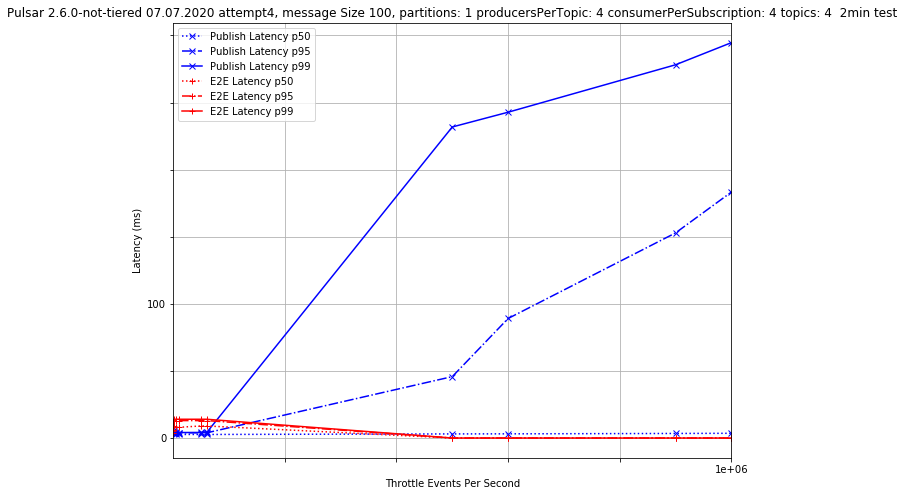

In [1580]:
plot_latency_vs_provided_rate_normal(filt_100_df)

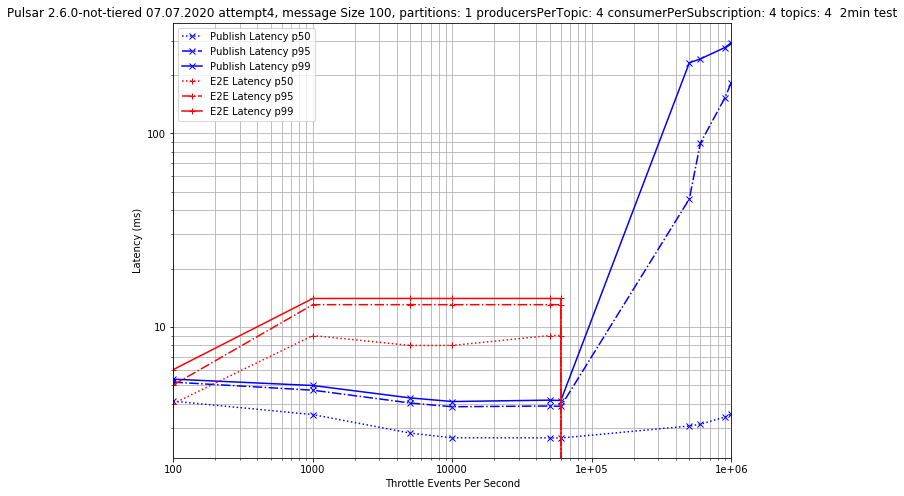

In [1581]:
plot_latency_vs_provided_rate(filt_100_df)

In [1582]:
latency_vs_provided_rate_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Throttle Events Per Second,,,,,,,
100.0,4.118,5.166,5.352,4.0,5.0,6.0,17447f03-f9dc-48e6-89f3-a7e7d7755ce8
1000.0,3.510,4.694,4.964,9.0,13.0,14.0,9ab6903d-33de-43bf-a124-f2b35cca9cac
5000.0,2.815,4.030,4.281,8.0,13.0,14.0,147c8b0f-8319-416d-b097-7e0317da0819
10000.0,2.663,3.854,4.101,8.0,13.0,14.0,2b3fcc77-8ce0-45c5-94db-b11d1262499b
50000.0,2.662,3.889,4.170,9.0,13.0,14.0,f2017380-fa00-4f14-bfd0-e0e2e5dba634
60000.0,2.655,3.873,4.151,9.0,13.0,14.0,b395ede9-cc42-4cdf-838e-67e4c9ec0c5a
500000.0,3.064,45.769,231.823,0.0,0.0,0.0,f0ccd198-2d02-4908-b835-b31e112b6b08
600000.0,3.127,89.083,242.821,0.0,0.0,0.0,55d9751e-c7e5-4dd9-bbc9-969f6627a8f5
900000.0,3.412,152.840,278.153,0.0,0.0,0.0,e6afa37b-446b-4479-a1a4-d11b4cedc9e0


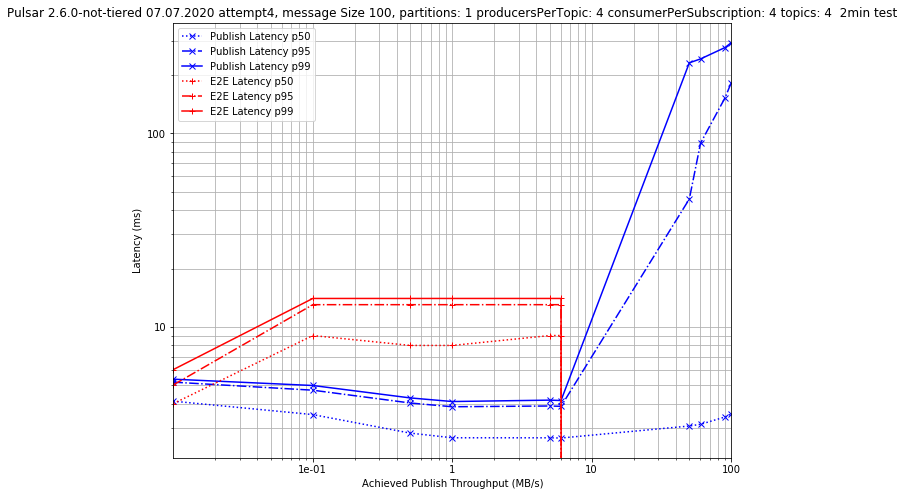

In [1583]:
plot_latency_vs_publish_throughput(filt_100_df)

In [1584]:
latency_vs_publish_throughput_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Publish Throughput (MB/s),,,,,,,
0.010016,4.118,5.166,5.352,4.0,5.0,6.0,17447f03-f9dc-48e6-89f3-a7e7d7755ce8
0.100202,3.510,4.694,4.964,9.0,13.0,14.0,9ab6903d-33de-43bf-a124-f2b35cca9cac
0.500849,2.815,4.030,4.281,8.0,13.0,14.0,147c8b0f-8319-416d-b097-7e0317da0819
1.002160,2.663,3.854,4.101,8.0,13.0,14.0,2b3fcc77-8ce0-45c5-94db-b11d1262499b
5.013429,2.662,3.889,4.170,9.0,13.0,14.0,f2017380-fa00-4f14-bfd0-e0e2e5dba634
6.030089,2.655,3.873,4.151,9.0,13.0,14.0,b395ede9-cc42-4cdf-838e-67e4c9ec0c5a
50.138148,3.064,45.769,231.823,0.0,0.0,0.0,f0ccd198-2d02-4908-b835-b31e112b6b08
60.342655,3.127,89.083,242.821,0.0,0.0,0.0,55d9751e-c7e5-4dd9-bbc9-969f6627a8f5
90.417909,3.412,152.840,278.153,0.0,0.0,0.0,e6afa37b-446b-4479-a1a4-d11b4cedc9e0


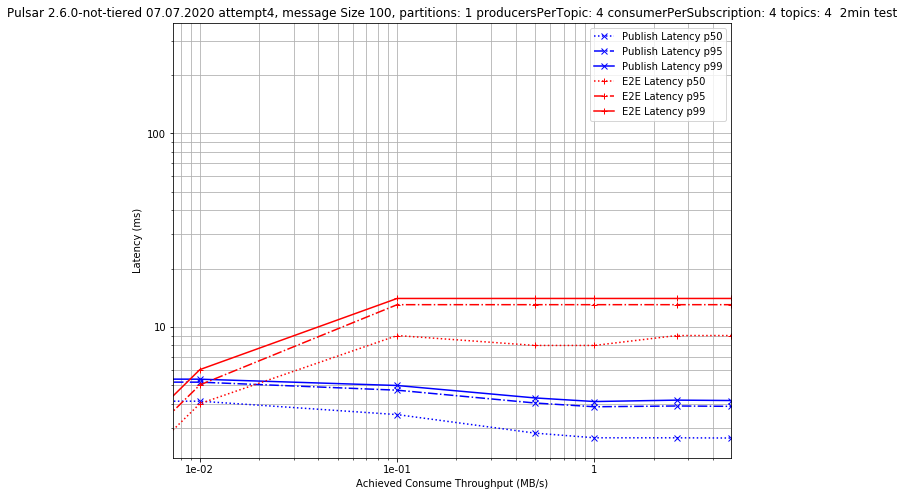

In [1585]:
plot_latency_vs_consume_throughput(filt_100_df)

In [1586]:
latency_vs_consume_throughput_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Consume Throughput (MB/s),,,,,,,
0.000000,3.535,183.266,294.635,0.0,0.0,0.0,fa6d8fd9-a1dd-4faf-93e5-60b4a7d6a5db
0.000000,3.412,152.840,278.153,0.0,0.0,0.0,e6afa37b-446b-4479-a1a4-d11b4cedc9e0
0.000000,3.064,45.769,231.823,0.0,0.0,0.0,f0ccd198-2d02-4908-b835-b31e112b6b08
0.000000,3.127,89.083,242.821,0.0,0.0,0.0,55d9751e-c7e5-4dd9-bbc9-969f6627a8f5
0.010016,4.118,5.166,5.352,4.0,5.0,6.0,17447f03-f9dc-48e6-89f3-a7e7d7755ce8
0.100205,3.510,4.694,4.964,9.0,13.0,14.0,9ab6903d-33de-43bf-a124-f2b35cca9cac
0.500827,2.815,4.030,4.281,8.0,13.0,14.0,147c8b0f-8319-416d-b097-7e0317da0819
1.002024,2.663,3.854,4.101,8.0,13.0,14.0,2b3fcc77-8ce0-45c5-94db-b11d1262499b
2.621242,2.662,3.889,4.170,9.0,13.0,14.0,f2017380-fa00-4f14-bfd0-e0e2e5dba634


## Message Size 10 KB

In [1587]:
filt_10000_df = filter_dataframe(
    filt_df,
    messageSize=10000,
    producersPerTopic=4,
    partitionsPerTopic=1,
    numWorkloadWorkers=4,
    #version='2.6.0-not-tiered'
    #version='2.5.2'
    version='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2'
)

filter_dataframe: No matching records after filtering on version=['0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2']


In [1588]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_10000_df[param_cols].drop_duplicates().T

test_uuid
numWorkloadWorkers
topics
partitionsPerTopic
producersPerTopic
subscriptionsPerTopic
consumerPerSubscription
testDurationMinutes
keyDistributor
git_commit
driverName


In [1589]:
plot_latency_vs_publish_throughput(filt_10000_df)

AssertionError: 

In [1590]:
latency_vs_publish_throughput_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Publish Throughput (MB/s),,,,,,,


In [1591]:
plot_latency_vs_consume_throughput(filt_10000_df)

AssertionError: 

In [1592]:
latency_vs_consume_throughput_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Consume Throughput (MB/s),,,,,,,


In [1593]:
plot_latency_vs_provided_rate(filt_10000_df)

AssertionError: 

In [1594]:
latency_vs_provided_rate_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Throttle Events Per Second,,,,,,,


## Analyze 100 B events, 50,000 events/sec, various number of partitions and producers

In [1595]:
filt_50000eps_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producerRate=-1,
).sort_values(['endToEndLatencyMs99Pct'], ascending=True)
len(filt_50000eps_df)

filter_dataframe: No matching records after filtering on producerRate=[-1]


0

In [1596]:
take_varying_columns(filt_50000eps_df[cols]).head(20)

""
test_uuid


# Analyze Latency Distribution

In [1597]:
test_uuid = filt_50000eps_df.iloc[0].name
test_uuid

IndexError: single positional indexer is out-of-bounds

In [1598]:
df = clean_df
t = df[df.test_uuid==test_uuid].iloc[0]

IndexError: single positional indexer is out-of-bounds

In [1599]:
# Cumulative Distribution Function
pubcdf = t.aggregatedPublishLatencyQuantiles
pubcdf.name = 'Publish Latency CDF'

In [1600]:
# Probability Distribution Function (latency histogram)
pubpdf = pd.Series(index=pubcdf.index, data=np.gradient(pubcdf, pubcdf.index.values), name='Publish Latency PDF')

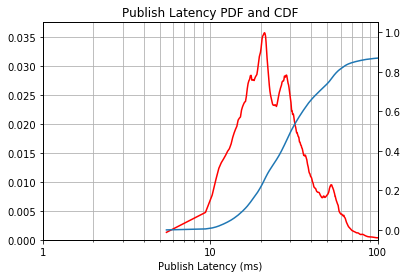

In [1601]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
pubpdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='Publish Latency PDF and CDF')
pubcdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('Publish Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

In [1602]:
# Cumulative Distribution Function
e2ecdf = t.aggregatedEndToEndLatencyQuantiles
e2ecdf.name = 'E2E Latency CDF'
# Probability Distribution Function (latency histogram)
e2epdf = pd.Series(index=e2ecdf.index, data=np.gradient(e2ecdf, e2ecdf.index.values), name='E2E Latency PDF')

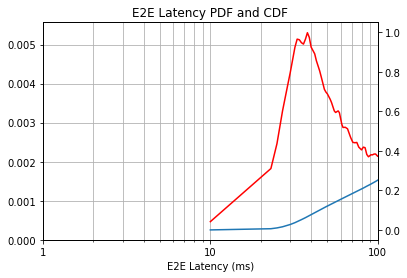

In [1603]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
e2epdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='E2E Latency PDF and CDF')
e2ecdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

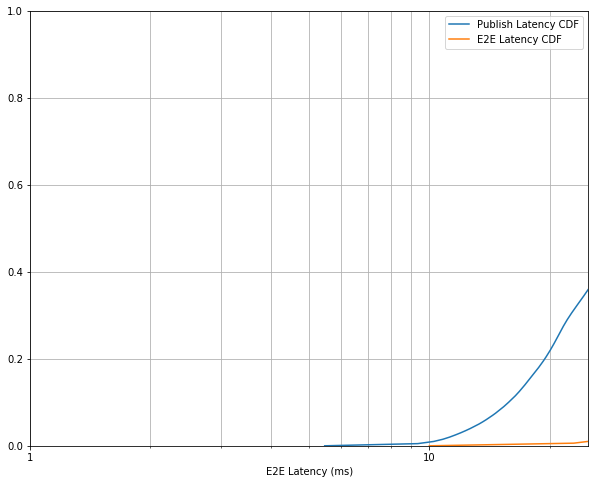

In [1604]:
# Combined publish and E2E latency CDF
fig0, ax0 = plt.subplots()
xlim=[1,25]
pubcdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True, figsize=(10,8))
e2ecdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True)
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

## Compare Two Sets

In [1629]:
# Common filter
filt_df = filter_dataframe(
    clean_df,
    numWorkloadWorkers=4, 
    topics=4,
    testDurationMinutes=2,
    #size_of_test_batch=(2,1000), # between
    #aggregatedEndToEndLatency50pct=(1,1e6),
    messageSize=10000,
    producersPerTopic=4,
    partitionsPerTopic=1,    
)
len(filt_df)

24

In [1630]:
# Set 1
filt1_df = filter_dataframe(
    filt_df,
    version='2.6.0-not-tiered',
    #pravegaVersion='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2' 
    #pravegaVersion='0.8.0-2656.1c40f1e-Isilon-tier2',
)
len(filt1_df)

11

In [1631]:
# Set 2
filt2_df = filter_dataframe(
    filt_df,
    #version='2.6.0-ecs-s3-tier2'
    version='2.5.2',
    #pravegaVersion='0.8.0-2656.1c40f1e-Isilon-tier2',
)
len(filt2_df)

13

In [1632]:
dfs = [filt1_df, filt2_df]
take_varying_columns(pd.concat(dfs)[param_cols]).drop_duplicates()

,git_commit,version
test_uuid,,
fdbfae2d-c81c-4359-8682-7dbf89ba987d,712d559,2.6.0-not-tiered
3da3a5c6-33e3-4c7a-bbd3-7c4e9529072f,326cb35,2.5.2


In [1633]:
def plot_latency_vs_throughput_comparison(dfs, legend_cols=None, latencyMetric='Publish'):
    fig0, ax0 = plt.subplots()
    cmap = plt.get_cmap('Set1')
    colors = cmap.colors[0:len(dfs)]
    pravegaVersion = filt1_df.version.iloc[0]
    pravegaDriver = filt1_df.driver.iloc[0]
    pulsarVersion = filt2_df.version.iloc[0]
    pulsaraDriver = filt2_df.driver.iloc[0]
    messageSize = filt2_df.messageSize.iloc[0]
    msgSize = '%db' % (messageSize)
    if messageSize >= 1000:
        msgSize = '%dk' % (messageSize/1000)
    
    partitionsPerTopic = filt2_df.partitionsPerTopic.iloc[0]
    testDurationMinutes = filt2_df.testDurationMinutes.iloc[0]
    topics = filt2_df.topics.iloc[0]
    producersPerTopic = filt2_df.producersPerTopic.iloc[0]
    consumerPerSubscription = filt2_df.consumerPerSubscription.iloc[0]
    
    title = 'Compare %s %s and %s %s [messageSize %s, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d] on %d min test' % (pravegaDriver, pravegaVersion, pulsaraDriver, pulsarVersion, msgSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
   
    for index, (df, color) in enumerate(zip(dfs, colors)):
        df = df.set_index(['publishRateMBPerSecMean']).sort_index()
        name_cols = df.iloc[0][legend_cols]
        name = ','.join(['%s=%s' % item for item in name_cols.to_dict().items()])
    
        plot_df = latency_vs_provided_rate_table(df)
        
        for percentile, style in [('50',':x'), ('95','-.x'), ('99','-x')]:
            plot_df = df[['aggregated%sLatency%spct' % (latencyMetric, percentile)]]
            plot_df.columns = ['%s %s Latency p%s' % (name, latencyMetric, percentile)]
            plot_df.index.name = 'Achieved Publish Throughput (MB/s)'
            plot_df.plot(
                ax=ax0,
                logx=True, 
                logy=True,
                figsize=(10,8),
                grid=True,
                style=style,
                color=color,
                title=title 
            )
    ax0.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax0.xaxis.set_major_formatter(tick_formatter)
    ax0.yaxis.set_major_formatter(tick_formatter)
    ax0.grid('on', which='both', axis='both')

In [1634]:
def plot_latency_vs_provided_rate_comparison(dfs, legend_cols=None, latencyMetric='Publish'):
    fig0, ax0 = plt.subplots()
    cmap = plt.get_cmap('Set1')
    colors = cmap.colors[0:len(dfs)]
    pravegaVersion = filt1_df.version.iloc[0]
    pravegaDriver = filt1_df.driver.iloc[0]
    pulsarVersion = filt2_df.version.iloc[0]
    pulsaraDriver = filt2_df.driver.iloc[0]
    messageSize = filt2_df.messageSize.iloc[0]
    msgSize = '%db' % (messageSize)
    if messageSize >= 1000:
        msgSize = '%dk' % (messageSize/1000)
    
    partitionsPerTopic = filt2_df.partitionsPerTopic.iloc[0]
    testDurationMinutes = filt2_df.testDurationMinutes.iloc[0]
    topics = filt2_df.topics.iloc[0]
    producersPerTopic = filt2_df.producersPerTopic.iloc[0]
    consumerPerSubscription = filt2_df.consumerPerSubscription.iloc[0]
    
    title = 'Compare %s %s and %s %s [messageSize %s, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d] on %d min test' % (pravegaDriver, pravegaVersion, pulsaraDriver, pulsarVersion, msgSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    
    for index, (df, color) in enumerate(zip(dfs, colors)):
        df = df.set_index(['throttleEventsPerSec']).sort_index()
        name_cols = df.iloc[0][legend_cols]
        name = ','.join(['%s=%s' % item for item in name_cols.to_dict().items()])
               
        for percentile, style in [('50',':x'), ('95','-.x'), ('99','-x')]:
            plot_df = df[['aggregated%sLatency%spct' % (latencyMetric, percentile)]]
            plot_df.columns = ['%s %s Latency p%s' % (name, latencyMetric, percentile)]
            plot_df.index.name = 'Provided Rate (Events/s)'
            plot_df.plot(
                ax=ax0,
                logx=True, 
                logy=True,
                figsize=(10,8),
                grid=True,
                style=style,
                color=color,
                title=title 
            )
    ax0.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax0.xaxis.set_major_formatter(tick_formatter)
    ax0.yaxis.set_major_formatter(tick_formatter)
    ax0.grid('on', which='both', axis='both')

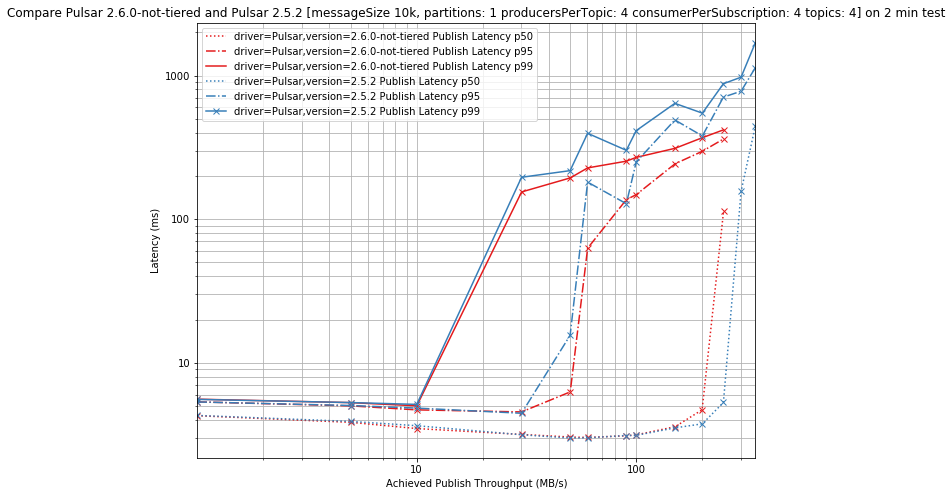

In [1635]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='Publish')

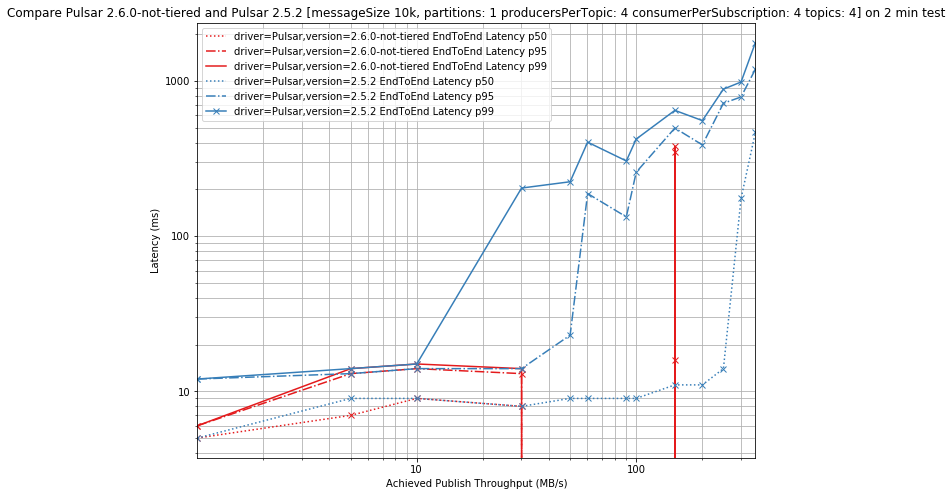

In [1636]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='EndToEnd')

In [1637]:
### Latency vs Provided Rate 

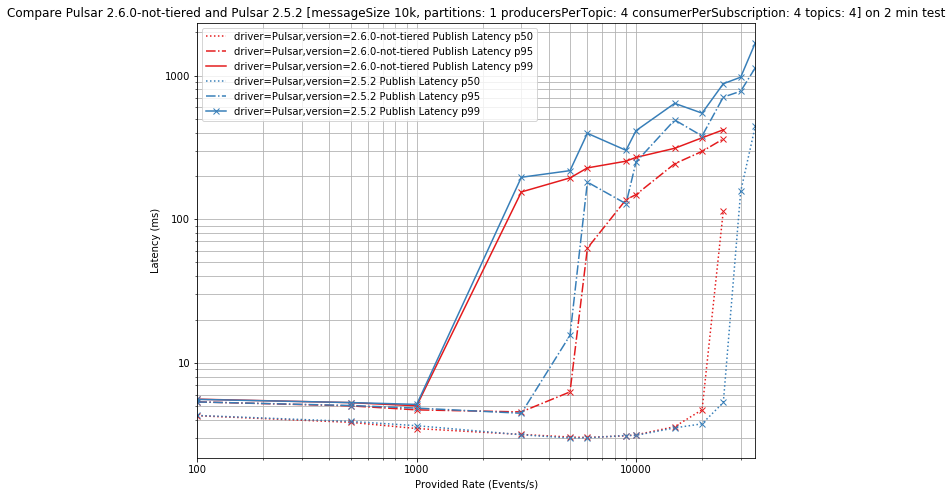

In [1638]:
plot_latency_vs_provided_rate_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='Publish')

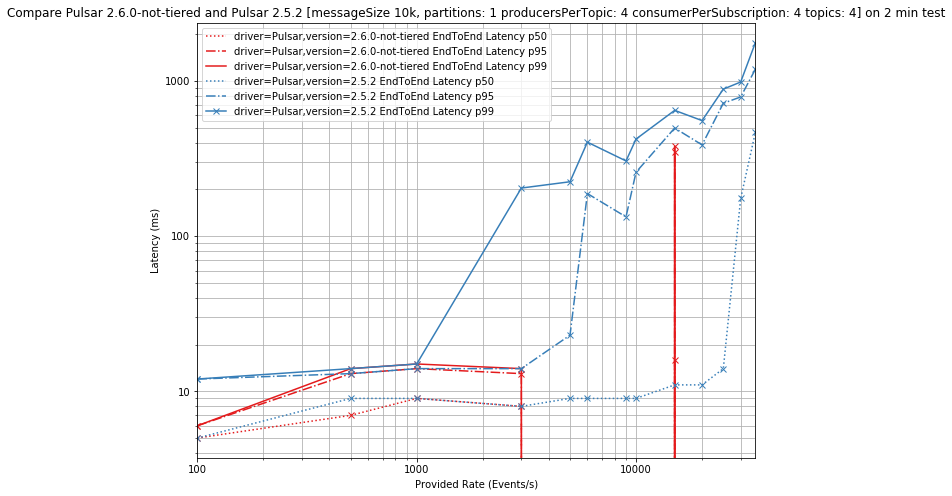

In [1639]:
plot_latency_vs_provided_rate_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='EndToEnd')